In [1]:
!pip install wordcloud


In [2]:

# -*- coding: utf-8 -*-
# Projeto: Análise de Sentimentos em Comentários de Livros
# Arquivo: analise_exploratoria.ipynb
# Descrição: Notebook para leitura do dataset da Amazon, análise exploratória e visualização básica.
#
# Integrantes:
# - Maria Gabriela Barros – RA: 10409037 – 10409037@mackenzista.com.br
# - Raphaela Polonis – RA: 10408843 – 10408843@mackenzista.com.br
# - Felipe Carvalho – RA: 1049804 – 104098043@mackenzista.com.br
# - Bruno Gustavo Rocha – RA: 1049804 – 104098043@mackenzista.com.br
#
# Histórico de alterações:
# - 20/09/2025 – Maria Gabriela Barros – Criação do notebook inicial com leitura do dataset e checagem do balanceamento.
# - 22/09/2025 – Raphaela Polonis – Implementação da etapa de pré-processamento (remoção de stopwords, limpeza de texto e normalização).
# - 23/09/2025 – Felipe Carvalho – Desenvolvimento da análise exploratória: histogramas, distribuição de classes e geração das nuvens de palavras.
# - 23/09/2025 – Bruno Gustavo Rocha – Implementação do modelo baseline (TF-IDF + Regressão Logística) e avaliação (acurácia, classification report, testes manuais).
# - 27/09/2025 – Raphaela Polonis – Organização do repositório GitHub (criação de pastas /dataset, /src, /notebooks e atualização do README).
# - 28/09/2025 – Maria Gabriela Barros – Revisão final do código, inclusão de exemplos de predições em frases novas e ajustes para entrega.
# - 28/09/2025 – Felipe Carvalho & Bruno Gustavo Rocha – Testes adicionais e validação final

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [15]:

# Lendo os arquivos de comentários positivos e negativos
with open("books_pt_pos.txt", "r", encoding="utf-8") as f:
    pos = f.readlines()
with open("books_pt_neg.txt", "r", encoding="utf-8") as f:
    neg = f.readlines()


# Criando DataFrames
df_pos = pd.DataFrame({"review": pos, "sentiment": "positivo"})
df_neg = pd.DataFrame({"review": neg, "sentiment": "negativo"})

# Unindo tudo em um único DataFrame
df = pd.concat([df_pos, df_neg]).reset_index(drop=True)
df.head()


,review,sentiment
0,Enfim o final da série chegou e me deixou arre...,positivo
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,positivo
2,"Lara smithe fechou a série com chave de ouro,q...",positivo
3,Mais uma vez a Lara Smithe nos deixa de boca a...,positivo
4,Ótima ideia: aglutinar os livros dos quatro ir...,positivo


sentiment
positivo    1000
negativo    1000
Name: count, dtype: int64


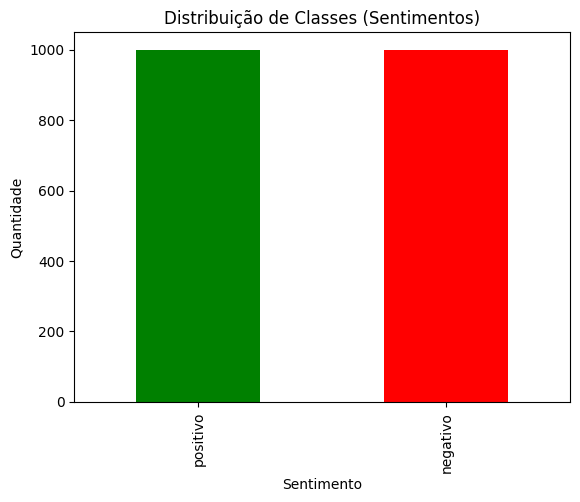

In [4]:

# Contagem de classes
print(df['sentiment'].value_counts())

# Visualizando em gráfico de barras
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribuição de Classes (Sentimentos)")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()


In [5]:

# Adicionando coluna com comprimento dos textos
df['length'] = df['review'].apply(len)
df['length'].describe()


,length
count,2000.000000
mean,362.187000
std,407.991167
min,1.000000
25%,152.000000
50%,244.000000
75%,411.000000
max,6805.000000


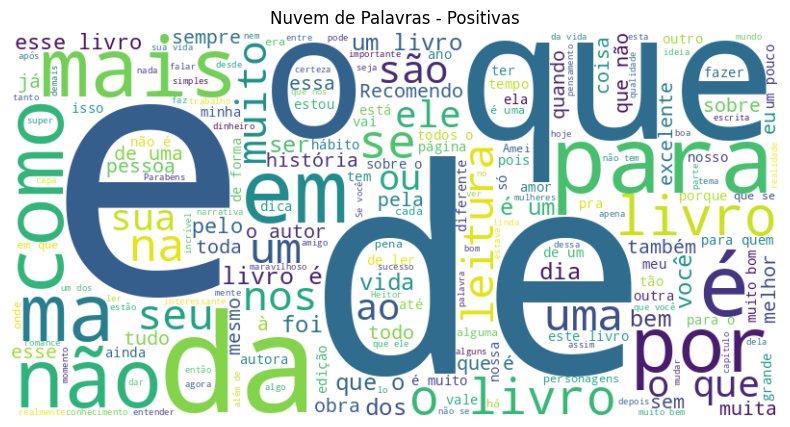

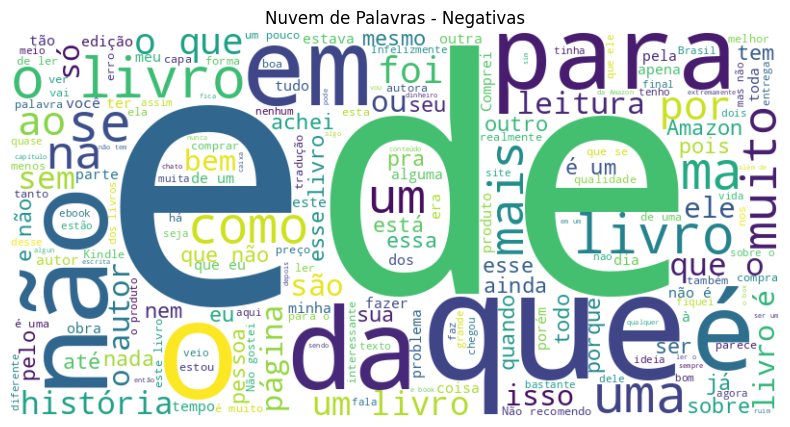

In [6]:

# Função para gerar nuvem de palavras por classe
def plot_wordcloud(texts, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# WordCloud para comentários positivos
plot_wordcloud(df[df['sentiment']=="positivo"]['review'], "Nuvem de Palavras - Positivas")

# WordCloud para comentários negativos
plot_wordcloud(df[df['sentiment']=="negativo"]['review'], "Nuvem de Palavras - Negativas")


In [8]:
# Instalar NLTK (se já não tiver)
!pip install nltk unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.4 MB/s eta 0:00:00


In [10]:
# Stopwords em português
stopwords_pt = set(stopwords.words("portuguese"))

def limpar_texto(texto):
    # Remove acentos
    texto = unidecode(texto)
    # Coloca em minúsculas
    texto = texto.lower()
    # Remove stopwords
    palavras = [p for p in texto.split() if p not in stopwords_pt]
    return " ".join(palavras)

# Criar nova coluna com texto limpo
df['clean_review'] = df['review'].apply(limpar_texto)

df[['review','clean_review']].head()


,review,clean_review
0,Enfim o final da série chegou e me deixou arre...,enfim final serie chegou deixou arrebatada emo...
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,aiai! agora ficamos orfaos lafaiete historia a...
2,"Lara smithe fechou a série com chave de ouro,q...","lara smithe fechou serie chave ouro,que amor l..."
3,Mais uma vez a Lara Smithe nos deixa de boca a...,"vez lara smithe deixa boca aberta, saber dizer..."
4,Ótima ideia: aglutinar os livros dos quatro ir...,otima ideia: aglutinar livros quatro irmaos la...


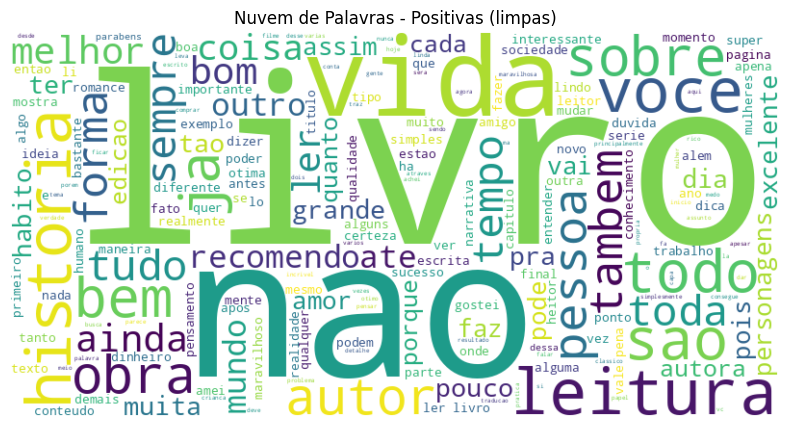

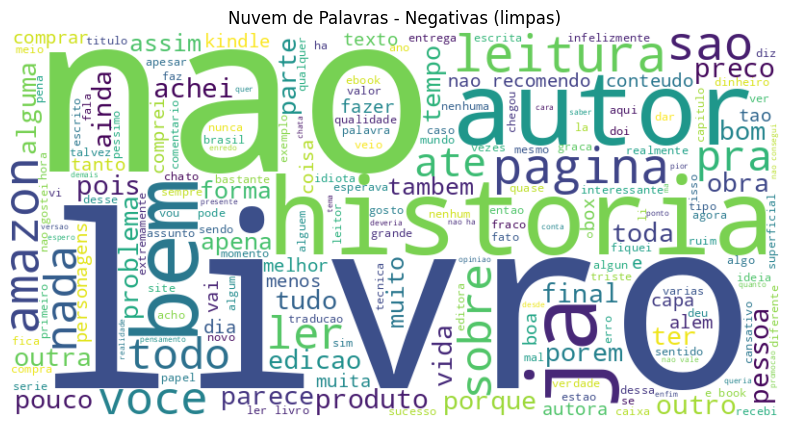

In [11]:
# Função para nuvem de palavras
def plot_wordcloud(texts, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# WordCloud para comentários positivos
plot_wordcloud(df[df['sentiment']=="positivo"]['clean_review'], "Nuvem de Palavras - Positivas (limpas)")

# WordCloud para comentários negativos
plot_wordcloud(df[df['sentiment']=="negativo"]['clean_review'], "Nuvem de Palavras - Negativas (limpas)")


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = df['clean_review']
y = df['sentiment'].map({"negativo":0, "positivo":1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["negativo","positivo"]))


Acurácia: 0.8825
              precision    recall  f1-score   support

    negativo       0.86      0.92      0.89       200
    positivo       0.91      0.84      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [26]:
exemplos = [
    "Amei a história, personagens cativantes e final emocionante!",
    "Péssimo, confuso e cansativo. Não recomendo.",
    "Achei ok, mas esperava mais do enredo."
]

ex_limpos = [clean_text(t) for t in exemplos]
pred = clf.predict(tfidf.transform(ex_limpos))

mapa = {0:"negativo", 1:"positivo"}
for txt, p in zip(exemplos, pred):
    print(f"[{mapa[int(p)]}] {txt}")


[positivo] Amei a história, personagens cativantes e final emocionante!
[negativo] Péssimo, confuso e cansativo. Não recomendo.
[negativo] Achei ok, mas esperava mais do enredo.
